<h1>**Boosting and Stacking methods on German Credit Risk data set**</h1>

# Tables of Content:

**1. [Introduction](#intro_bst)** <br>
    - Information about the data set <br>
**2. [Reason for using this model](#reasons_bst)** <br>
    - The purpose of this specific model <br>
**3. [Libraries](#libraries_bst)** <br>
    - Importing Libraries <br>
    - Importing Dataset <br>
**4. [Preprocess](#preprocessing_bst)** <br>
    - 4.1 Separating feature and target variables <br>
    - 4.2 [Feature Selection](#feature_selection_bst)<br>
    - 4.3 [Spliting the X and Y in train and test](#split_bst)<br>
**5. [Models](#modelling_bst)**<br>
    - 5.1 GradientBoostingClassifier<br>
    - 5.2 GradientBoostingClassifier with GridSearchCV<br>
    - 5.3 AdaBoostClassifier with GridSearchCV<br>
    - 5.4 XGBoost<br>
    - 5.5 VotingClassifier<br>
    - 5.6 [Metrics](#metrics_bst)<br>
    - 5.6 [Confusion Matrix and Classification Report](#conmat_bst)<br>
    - 5.7 ROC curve and Precision Recall curve<br>
**6. [Conclusion and Benefits of the model](#summary_bst)** <br>
    The summary of the model implementation

<a id="intro_bst"></a> <br>
# **1. Introduction:** 
<h2>Context</h2>
The original dataset contains 1000 entries with 9 feature variables. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

<h2>Content</h2>
I have cleaned and preprocessed the data already and also I have created a more relevant feature from two of the most important feature in the data set i.e. Credit amount and Duration. The preprocessed data set is already saved in a CSV file and we are going to use that file for our model training and testing purposes. The selected variables from the orginal data set are:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

<a id="resons_bst"></a> <br>
# **2. Reason for using this model**
<h2>Our goal is to: </h2>

- Implement GradientBoostingClassifier with and without GridSearchCV, AdaBoostClassifier with GridSearchCV, and stacking alogorithm like VotingClassifier (in which, we are going to stack LogisticClassifier with l2 penalty and GradientBoostingClassifier.
- Moreover, we are going to assess various metrics for these models and plot area-under-curve and precision-recall curve.
- We are going to estimate the best estimator i.e. the best hyperparameters for our models.
- False Positive Rate are calculated using confusion matrix to better understand the potentiality of losses which will incur due to giving loans to the person who will default.

<a id="libraries_bst"></a> <br>
# **3. Libraries**

### Imports

In [3]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

from scipy import stats 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from colorsetup import colors, palette

### Read the Data

In [4]:
gcr_data = pd.read_csv("gcr_processed.csv")

<a id="preprocessing_bst"></a> <br>
# **4. Preprocess**

<h2>4.1 Separating feature and target</h2>

In [5]:
#X = gcr_data.drop(['Risk','Credit amount', 'Duration'], axis=1)
X = gcr_data.drop(['Risk','Credit_amount/duration'], axis=1)
y = gcr_data['Risk']

<a id="feature_selection_bst"></a>
<h2>4.2 Feature Selection</h2>

### 1. Univariate Selection

In [6]:
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print best features

                         Specs      Score
12     Checking account_little  48.450469
13   Checking account_moderate  10.453001
8       Saving accounts_little  10.291479
20            Purpose_radio/TV   8.231293
7                 Housing_rent   7.068103
11        Saving accounts_rich   7.000000
5                 Housing_free   5.932981
6                  Housing_own   5.198758
10  Saving accounts_quite rich   4.717309
4                     Duration   4.699713


In [7]:
#X = gcr_data[featureScores.nlargest(23, 'Score')['Specs'].values]

### 2. Feature Importance

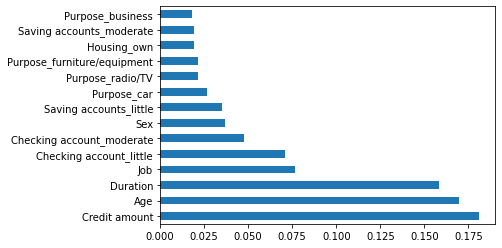

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

model_fi = ExtraTreesClassifier()
model_fi.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_fi.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).nlargest(14).plot(kind='barh')
plt.show()

In [10]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results = list()
for i in range(1,24):
        scores = evaluate_model(model_fi, X[feat_importances.nlargest(i).index], y)
        results.append(scores)
        print('> %s) %.3f (%.3f)' % (i, mean(scores), std(scores)))

> 1) 0.594 (0.030)
> 2) 0.608 (0.039)
> 3) 0.663 (0.043)
> 4) 0.668 (0.035)
> 5) 0.727 (0.039)
> 6) 0.719 (0.036)
> 7) 0.718 (0.033)
> 8) 0.728 (0.039)
> 9) 0.724 (0.035)
> 10) 0.714 (0.028)
> 11) 0.720 (0.034)
> 12) 0.709 (0.023)
> 13) 0.714 (0.031)
> 14) 0.716 (0.029)
> 15) 0.708 (0.027)
> 16) 0.710 (0.025)
> 17) 0.706 (0.034)
> 18) 0.708 (0.030)
> 19) 0.708 (0.032)
> 20) 0.710 (0.024)
> 21) 0.710 (0.027)
> 22) 0.711 (0.027)
> 23) 0.712 (0.028)


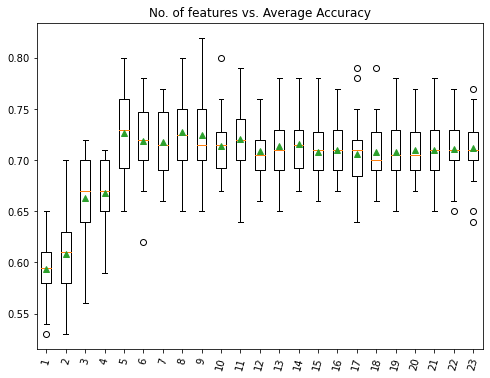

In [11]:
no_of_features = [str(i) for i in range(1,24)]
# plot model performance for comparison
plt.figure(figsize=(8,6))
plt.boxplot(results, labels=no_of_features, showmeans=True)
plt.xticks(rotation=75)
plt.title('No. of features vs. Average Accuracy')
plt.show()

### 3. Correlation Matrix with Heatmap

### 4. RFE

In [12]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = GradientBoostingClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = GradientBoostingClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = GradientBoostingClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = GradientBoostingClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = GradientBoostingClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [13]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s) %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr) 0.727 (0.030)
>per) 0.703 (0.035)
>cart) 0.730 (0.036)
>rf) 0.736 (0.036)
>gbm) 0.729 (0.045)


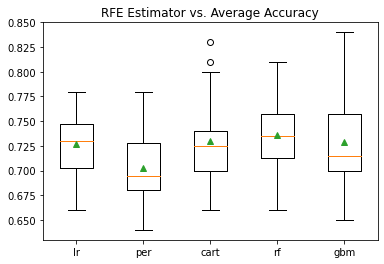

In [14]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title('RFE Estimator vs. Average Accuracy')
plt.show()

In [15]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 24):
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i)
        model = GradientBoostingClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('> %s) %.3f (%.3f)' % (name, mean(scores), std(scores)))

> 2) 0.686 (0.023)
> 3) 0.698 (0.034)
> 4) 0.717 (0.036)
> 5) 0.733 (0.031)
> 6) 0.739 (0.030)
> 7) 0.745 (0.030)
> 8) 0.745 (0.040)
> 9) 0.747 (0.037)
> 10) 0.742 (0.036)
> 11) 0.745 (0.035)
> 12) 0.745 (0.033)
> 13) 0.749 (0.034)
> 14) 0.745 (0.036)
> 15) 0.742 (0.035)
> 16) 0.746 (0.037)
> 17) 0.744 (0.037)
> 18) 0.745 (0.038)
> 19) 0.747 (0.032)
> 20) 0.749 (0.035)
> 21) 0.746 (0.039)
> 22) 0.747 (0.036)
> 23) 0.744 (0.035)


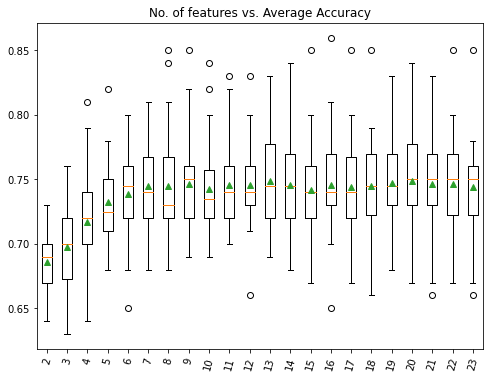

In [16]:
# plot model performance for comparison
plt.figure(figsize=(8,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=75)
plt.title('No. of features vs. Average Accuracy')
plt.show()

In [24]:
# define RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=13)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 5.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 2.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 7.000
Column: 11, Selected False, Rank: 8.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 6.000
Column: 15, Selected False, Rank: 3.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 11.000
Column: 18, Selected False, Rank: 4.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected False, Rank: 9.000
Column: 22, Selected False, Rank: 10.000


<a id="split_bst"></a>
<h2>4.3 StratifiedShuffleSplit</h2>

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 23), (700,), (300, 23), (300,))

<a id="modelling_bst"></a> <br>
# **5. Models**

#### Suppressing any warnings

In [27]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

<h2>5.1 GradientBoostingClassifier</h2>

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred_gb = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred_gb)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

# error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


#### Plot the Results

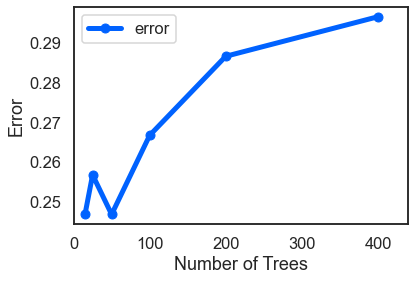

In [29]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette(palette)

# Create the plot
ax = error_df.plot(marker='o', figsize=(6, 4), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

<h2>5.2 GradientBoostingClassifier with GridSearchCV</h2>

In [30]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=3, random_state=42)

<h2>5.3 AdaBoostClassifier with GridSearchCV</h2>

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=200)

<h2>5.4 XGBoost</h2>

In [32]:
from xgboost import XGBClassifier

XGBC = XGBClassifier()
XGBC.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<h2>5.5 VotingClassifier</h2>

In [33]:
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough.

<a id="metrics_bst"></a>
<h2>5.6 Metrics</h2>

In [34]:
y_pred = list()
y_prob = list()

labels = ['GBC', 'GV_GBC', 'GV_ABC', 'VC', 'XGBC', 'LR_L2']
models = [GBC, GV_GBC, GV_ABC, VC, XGBC, LR_L2]

for lab,mod in zip(labels, models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,GBC,GV_GBC,GV_ABC,VC,XGBC,LR_L2
precision,0.679656,0.742243,0.723630,0.750737,0.726584,0.712314
recall,0.703333,0.756667,0.713333,0.763333,0.740000,0.733333
fscore,0.684426,0.735037,0.616814,0.742296,0.729659,0.708715
accuracy,0.703333,0.756667,0.713333,0.763333,0.740000,0.733333
auc,0.600794,0.651587,0.528571,0.659524,0.658730,0.622222


<a id="conmat_bst"></a>
<h2>5.6 Confusion Matrix and Classification Report</h2>

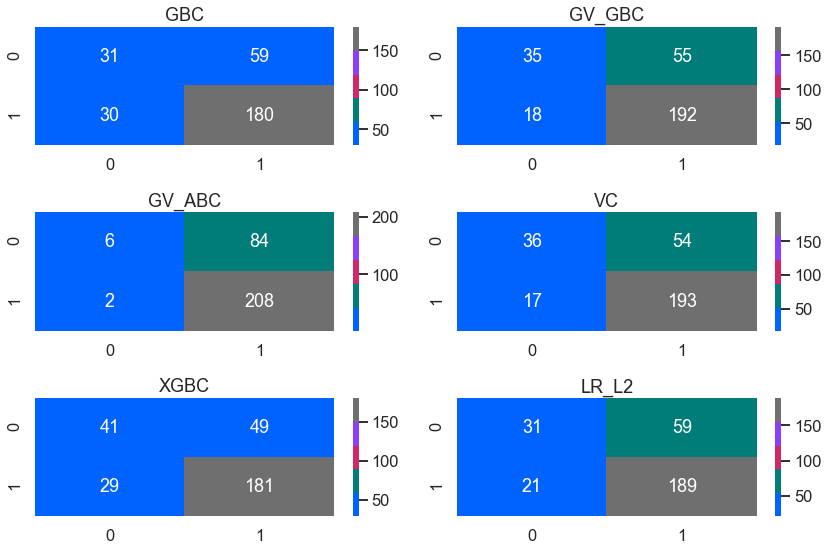

In [35]:
sns.set_context('talk')

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 8)


for ax,lab in zip(axList, labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

In [36]:
from sklearn.metrics import classification_report, f1_score

print('#'*60)

y_pred_gb = GBC.predict(X_test)
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gb))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_gb), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_gb), 3))

print('\n')
print('#'*60)

y_pred_gv_gb = GV_GBC.predict(X_test)
print('GradientBoostingClassifier with GridSearchCV')
print(classification_report(y_test, y_pred_gv_gb))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_gv_gb), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_gv_gb), 3))

print('\n')
print('#'*60)

y_pred_gv_abc = GV_ABC.predict(X_test)
print('AdaBoostClassifier with GridSearchCV')
print(classification_report(y_test, y_pred_gv_abc))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_gv_abc), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_gv_abc), 3))

print('\n')
print('#'*60)

y_pred_xgbc = XGBC.predict(X_test)
print('XGBoost')
print(classification_report(y_test, y_pred_gv_abc))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_xgbc), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_xgbc), 3))

print('\n')
print('#'*60)

y_pred_vc = VC.predict(X_test)
print('VotingClassifier')
print(classification_report(y_test, y_pred_vc))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_vc), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_vc), 3))

############################################################
GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.51      0.34      0.41        90
           1       0.75      0.86      0.80       210

    accuracy                           0.70       300
   macro avg       0.63      0.60      0.61       300
weighted avg       0.68      0.70      0.68       300

Accuracy score:  0.703
F1 Score:  0.802


############################################################
GradientBoostingClassifier with GridSearchCV
              precision    recall  f1-score   support

           0       0.66      0.39      0.49        90
           1       0.78      0.91      0.84       210

    accuracy                           0.76       300
   macro avg       0.72      0.65      0.66       300
weighted avg       0.74      0.76      0.74       300

Accuracy score:  0.757
F1 Score:  0.84


############################################################
AdaBoost

<h2>5.7 ROC curve and Precision-Recall curve</h2>

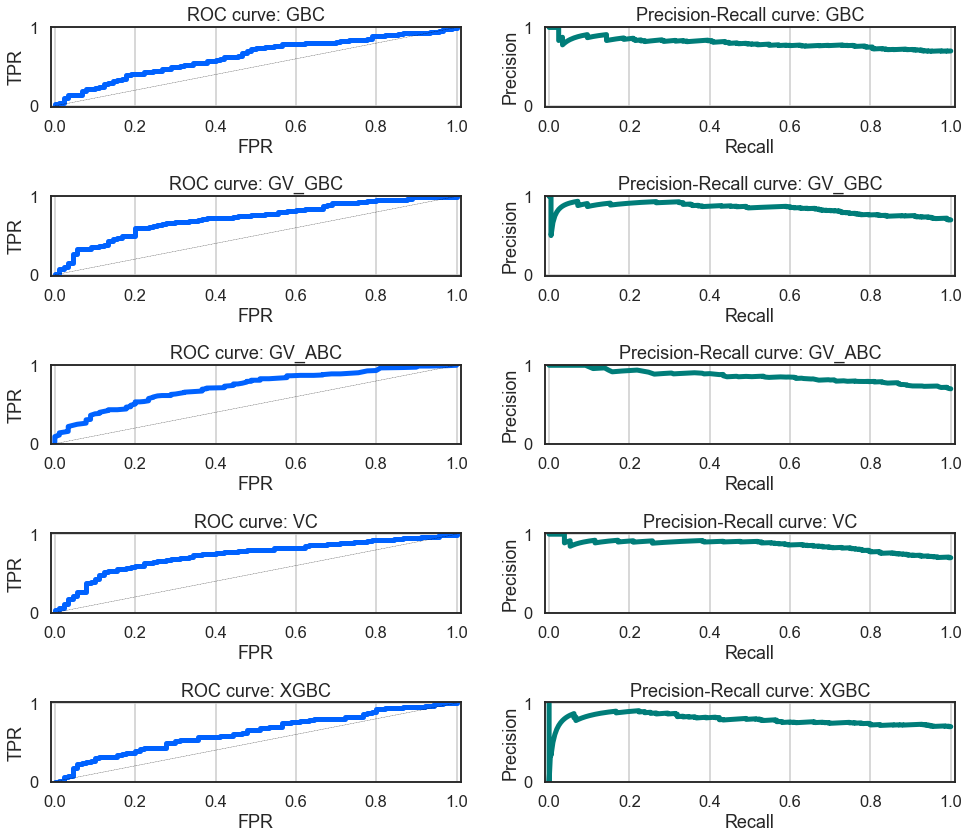

In [37]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')

fig, axList = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(14, 12)

for i, lab in zip(range(5),labels):

    # Plot the ROC-AUC curve

    ax = axList[i][0]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[lab])
    ax.plot(fpr, tpr, color=colors[0], linewidth=5)

    # It is customary to draw a diagonal dotted line in ROC plots.
    # This is to indicate completely random prediction. Deviation from this
    # dotted line towards the upper left corner signifies the power of the model.
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='FPR',
           ylabel='TPR',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve: {}'.format(lab))
    ax.grid(True)

    # Plot the precision-recall curve

    ax = axList[i][1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[lab])
    ax.plot(recall, precision, color=colors[1], linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve: {}'.format(lab))
    ax.grid(True)

plt.tight_layout()

<a id="summary_bag"></a> <br>
# **6. Conclusion and Benefits of the model**

- For the GradientBoostingTree algorithm, the optimum number of trees comes around 50 as we are getting the minimum error at that point when we plot 'error vs. number of trees'.
- Using the 'best_estimator_' attribute, we are getting the best hyperparameters for the models and they are used in prediction purpose.
- The comparison of the metrics of the model suggests that the GradientBoostingTree algorithm with GridSearchCV performs better than the other models as it gives the maximum accuracy of 77%. Also, it performs best among the models in predicting both the classes.
- However, the GradientBoostingTree algorithm without GridSearchCV has maximum False Positive Rate (about 45%) among the models and it becomes evident that the GridSearchCV performs better in reducing the FPR which gives the value of 31% when GradientBoostingTree algorithm with GridSearchCV is used.
- The AdaBoostClassifier with GridSearchCV gives the minimum FPR among the models which is 25% and 71.3% accuracy.
- The XGBoost also gives the FPR of 25% with accuracy 76.7%.
- The stacking algorithm used i.e. the VotingClassifier also gives 35% FPR with 75.7% accuracy. It is trained using two estimators of LogisticClassifier with l2 penalty and GradientBoostingTree algorithm with GridSearchCV.

########################################################################################################################################